In [ ]:
# Let's import the needed packages

# To deal with arrays 
import xarray as xr
import pandas as pd 
pd.options.mode.chained_assignment = None
import numpy as np

# To plot the Nino 3.4 index
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# To plot the map
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
# Data path
sst_data_path = 'data/sst.mnmean.nc'

# Upload the data under a xr array format
sst_ds = xr.open_dataset(sst_data_path)

# To check the data Structure
# print(sst_ds)

# To plot the dimensions and attributes of the data 
#sst_ds.info()

#Let's verify that there is no NaN in our dataset 
nan_count = np.isnan(sst_ds).sum()
print(f"Number of NaNs in sst_ds : {nan_count}")

Nombre de NaNs dans sst_ds : <xarray.Dataset>
Dimensions:    ()
Data variables:
    sst        int32 0
    time_bnds  int32 0


Great ! There are no NaNs in the dataset so we don't have to deal with data imputation.

In [3]:
# Now we have to restrict the zone to study and label the El-Nino temperature anomalies
# https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_advisory/enso-alert-readme.shtml#:~:text=The%20Climate%20Prediction%20Center%20defines...%20%22El%20Ni%C3%B1o%20conditions%22,Ni%C3%B1o%20Index%20%28ONI%29%20threshold%20will%20be%20met%2C%20AND
# Niño 3.4 Zone(5°N-5°S, 170°W-120°W)

#Latitudes: convert 5°N-5°S to the format [-90°, 90°] N->S
nino_lat_min = -5  
nino_lat_max = 5   

# Longitudes : convert 170°W and 120°W to the format [0°E, 360°E]
# 170°W = 360 - 170 = 190°E
# 120°W = 360 - 120 = 240°E
nino_lon_min = 190
nino_lon_max = 240

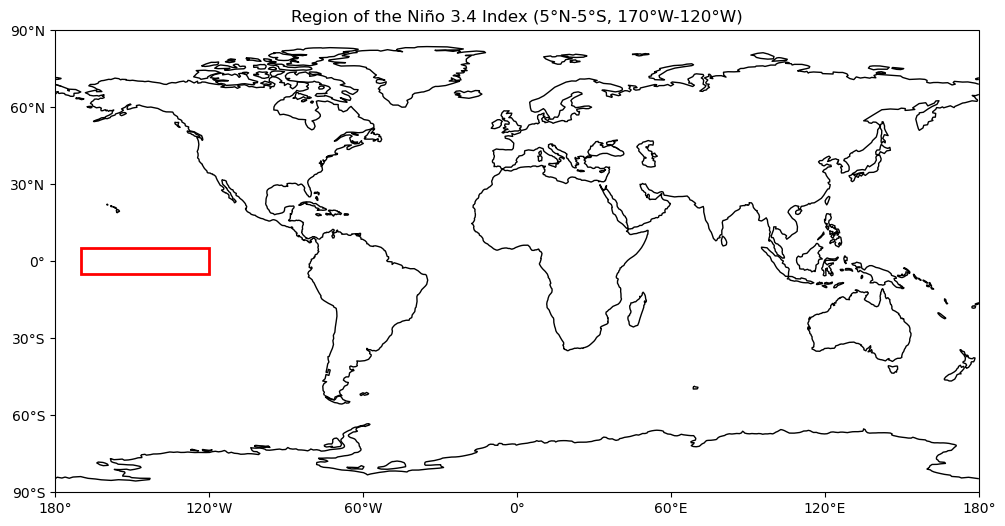

In [4]:
# Let's vizualize the Nino 3.4 zone 
plt.figure(figsize = [12, 6])
ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()

# Define the box of the restricted area 
nino34_box = patches.Rectangle(xy = [nino_lon_min, nino_lat_min], width = nino_lon_max - nino_lon_min, height = nino_lat_max - nino_lat_min, linewidth = 2, edgecolor = 'red', facecolor = 'none', transform = ccrs.PlateCarree())
ax.add_patch(nino34_box)

# Add Labels and Title
ax.set_xticks(range(-180, 181, 60), crs = ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 30), crs = ccrs.PlateCarree())
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())
plt.title("Region of the Niño 3.4 Index (5°N-5°S, 170°W-120°W)")
plt.savefig("images/El_Nino_Index_3.4.png")

plt.show()

In [5]:
#Let's now focus on the temperature variation on the Nino 3.4 zone 

# We define the Nino 3.4 region 
nino34_zone = sst_ds.sst.where(
    (sst_ds.lat >= nino_lat_min) & (sst_ds.lat <= nino_lat_max) &
    (sst_ds.lon >= nino_lon_min) & (sst_ds.lon <= nino_lon_max), drop=True #drops data outside of the box
)

# We average data on the Nino 3.4 zone and substract the temporal mean to establish a baseline
nino_sst_anomaly = nino34_zone.mean(dim = ["lat", "lon"]) - nino34_zone.mean(dim = ["lat", "lon"]).mean(dim = "time")

# Compute the Nino events 
nino_events = nino_sst_anomaly.where(nino_sst_anomaly >= 0.5, drop = True) 
nino_months = pd.to_datetime(nino_events.time.values)

# print("Dates of the El Nino Events:", nino_months)

print(nino_sst_anomaly)

<xarray.DataArray 'sst' (time: 475)>
array([-0.8223324 , -0.35479355, -0.3773117 ,  0.11966705,  0.94070816,
        1.4572277 ,  1.6717091 ,  1.0210896 ,  0.8544884 ,  1.0295296 ,
        1.5657063 ,  1.728487  ,  2.1361084 ,  2.2814293 ,  2.0488281 ,
        1.9533672 ,  1.8276291 ,  1.8166084 ,  1.1618462 , -0.01251221,
       -0.5506115 , -0.63781166, -1.2093925 , -1.4977112 , -1.4916344 ,
       -1.4366112 , -0.6917305 , -0.21293259,  0.31368637,  0.30902863,
       -0.22167015, -0.33358955, -0.73324966, -0.6526718 , -1.1501312 ,
       -1.6636925 , -2.076992  , -1.6455727 , -1.4094105 , -0.8526726 ,
       -0.27979088,  0.03630829, -0.21341133, -0.3839302 , -0.5730705 ,
       -0.82767296, -0.88653183, -0.88781357, -0.9699707 , -1.2911911 ,
       -1.1396923 , -0.42623138,  0.3607273 ,  0.41920853,  0.61192894,
        0.28964806,  0.0746479 ,  0.25698853,  0.49112892,  0.6532688 ,
        0.6255474 ,  0.82714844,  0.9390278 ,  1.3869076 ,  1.7182503 ,
        1.6697063 ,  1.9489

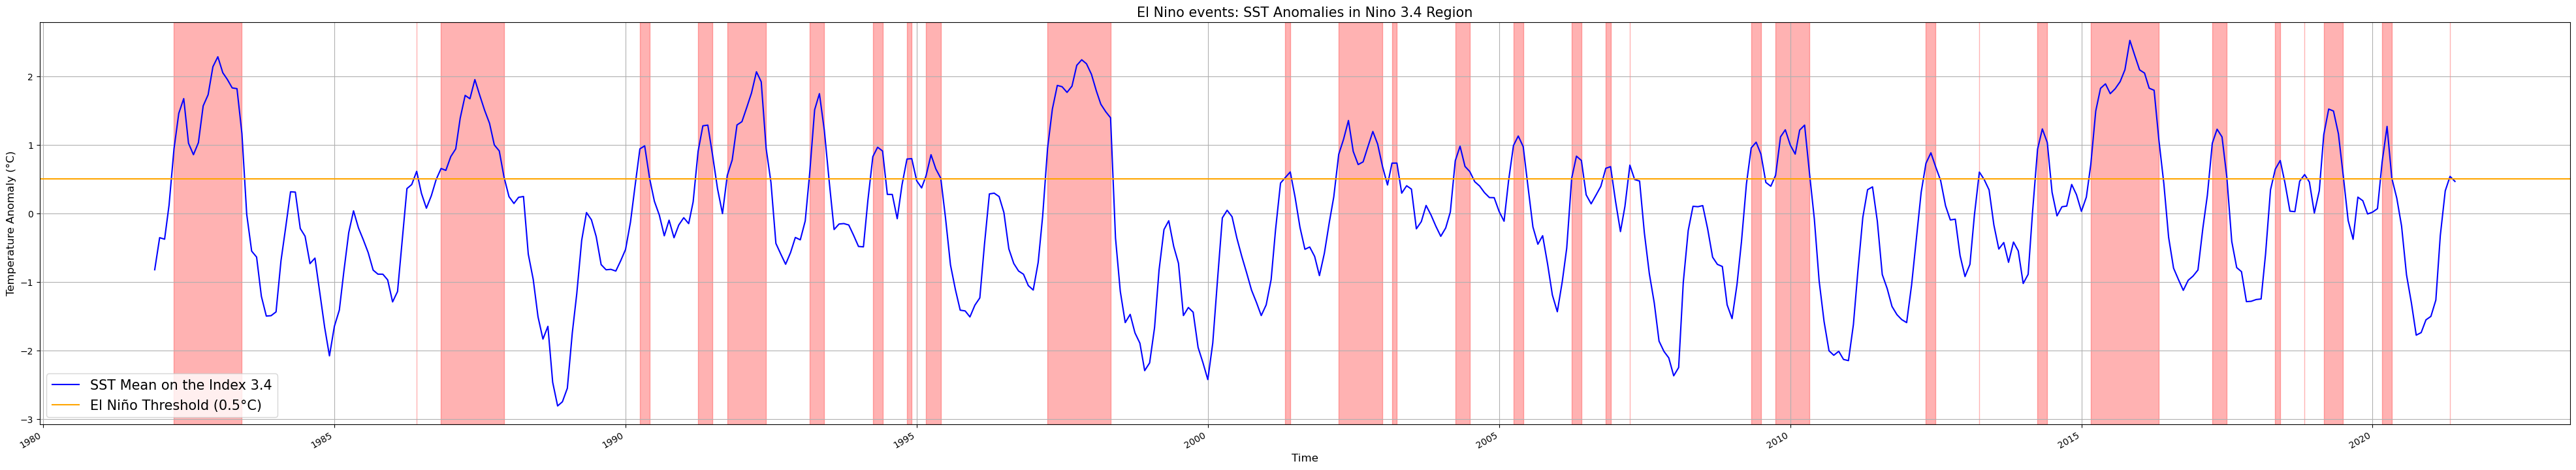

In [6]:
# Let's visualize the Nino Events 

plt.figure(figsize = [50, 8])
nino_sst_anomaly.plot(label = "SST Mean on the Index 3.4", color = "blue")

el_nino_periods = (nino_sst_anomaly >= 0.5).astype(int)

# Find the transitions between neutral and non-nino
transitions = np.diff(el_nino_periods, prepend = 0, append = 0)
start_indices = np.where(transitions == 1)[0]  # Beginning of a Nino phase
end_indices = np.where(transitions == -1)[0]  # End of a Nino phase 

# Add a color to show the Nino periods
for start, end in zip(start_indices, end_indices):
    plt.axvspan(nino_sst_anomaly.time[start].values, nino_sst_anomaly.time[end - 1].values, color = 'red', alpha = 0.3)

# Show the decision threshold
plt.axhline(0.5, color = 'orange', label = "El Niño Threshold (0.5°C)")

# Add Titles and legends
plt.title("El Nino events: SST Anomalies in Nino 3.4 Region", fontsize = 15)
plt.xlabel("Time", fontsize = 12)
plt.ylabel("Temperature Anomaly (°C)", fontsize = 12)
plt.legend(fontsize = 15)
plt.grid(True)

# Save the graph
plt.savefig("images/Temperatures_anomalies.png")
plt.show()

In [7]:
# Let's create our dataset for the prediction 1 month in advance
# We have to suppress the First and the Last month of the original dataset
all_months = pd.to_datetime(nino_sst_anomaly.time.values)

# Let's create y: assign 1 if there is a El Nino event in the following month, 0 otherwise 
y_1m = []
for i in range(0, len(all_months) - 1): 
    next_month = all_months[i + 1]
    if next_month in nino_months:
        y_1m.append(1)
    else:
        y_1m.append(0)

y_1m = np.array(y_1m)

# Let's create X: extract the SST data for all valid months
sst_global_data = sst_ds.sst.sel(time = slice(all_months[0], all_months[-2]))
X_1m = sst_global_data.values.reshape(len(all_months) - 1, -1)  #Flatten the data by month 

# Verify that the size are correct 
print(X_1m.shape, y_1m.shape)

#Save the data under the format .npz
np.savez_compressed("data/preprocessed_data/nino_dataset_1m.npz", X=X_1m, y=y_1m)


(474, 64800) (474,)


In [8]:
# Prediction 2 months in advance
# We have to suppress the last two months of the original dataset

y_2m = []
for i in range(0, len(all_months) - 2):  # Stop 2 months before the end
    next_2_months = all_months[i + 2]
    if next_2_months in nino_months:
        y_2m.append(1)
    else:
        y_2m.append(0)

y_2m = np.array(y_2m)

# Extract SST data for all months, excluding the last two 
sst_global_data_2m = sst_ds.sst.sel(time = slice(all_months[0], all_months[-3]))
X_2m = sst_global_data_2m.values.reshape(len(all_months) - 2, -1)  # Flatten the data by month

# Verify sizes
print(X_2m.shape, y_2m.shape)

# Save the dataset
np.savez_compressed("data/preprocessed_data/nino_dataset_2m.npz", X = X_2m, y = y_2m)

(473, 64800) (473,)


In [9]:
# Prediction 3 months in advance
# We have to suppress the last three months of the original dataset
y_3m = []
for i in range(0, len(all_months) - 3):  # Stop 3 months before the end
    next_3_months = all_months[i + 3]
    if next_3_months in nino_months:
        y_3m.append(1)
    else:
        y_3m.append(0)

y_3m = np.array(y_3m)

# Extract SST data for all valid months, excluding the last three months
sst_global_data_3m = sst_ds.sst.sel(time = slice(all_months[0], all_months[-4]))
X_3m = sst_global_data_3m.values.reshape(len(all_months) - 3, -1)  # Flatten the data by month

# Verify sizes
print(X_3m.shape, y_3m.shape)

# Save the dataset
np.savez_compressed("data/preprocessed_data/nino_dataset_3m.npz", X = X_3m, y = y_3m)


(472, 64800) (472,)


In [26]:
def get_data_N_month_in_advance(N):
    # Prediction N months in advance
    # We have to suppress the last three months of the original dataset
    y_m = []
    for i in range(0, len(all_months) - N):  # Stop N months before the end
        next_3_months = all_months[i + N]
        if next_3_months in nino_months:
            y_m.append(1)
        else:
            y_m.append(0)

    y_m = np.array(y_m)

    # Extract SST data for all valid months, excluding the last three months
    sst_global_data_m = sst_ds.sst.sel(time = slice(all_months[0], all_months[-(N+1)]))
    X_m = sst_global_data_m.values.reshape(len(all_months) - N, -1)  # Flatten the data by month

    # Verify sizes
    print(X_m.shape, y_m.shape)

    # Save the dataset
    np.savez_compressed(f"data/preprocessed_data/nino_dataset_{N}m.npz", X = X_m, y = y_m)


In [ ]:
# Get the data for several predictions
for i in range(4, 13):
    get_data_N_month_in_advance(i)

(471, 64800) (471,)
(470, 64800) (470,)
(469, 64800) (469,)
(468, 64800) (468,)
(467, 64800) (467,)
(466, 64800) (466,)
(465, 64800) (465,)
(464, 64800) (464,)
(463, 64800) (463,)


In [11]:
# Let's compare our results with the results from NOAA 
# "https://psl.noaa.gov/data/correlation/nina34.anom.data"

# Transform the anomalies as a dataframe
nino_sst_anomaly_df = nino_sst_anomaly.to_dataframe().reset_index()
nino_sst_anomaly_df = nino_sst_anomaly_df.rename(columns = {nino_sst_anomaly.name: "anomaly_calculated"})

# Load the NOAA data file and parse it
noaa_data_url = "https://psl.noaa.gov/data/correlation/nina34.anom.data"
noaa_data = pd.read_csv(noaa_data_url, sep= r'\s+', skiprows = 1, header = None)

years = noaa_data.iloc[:-3, 0].astype(int) 
months_data = noaa_data.iloc[:-3, 1:]  

# Transform the data into time series
dates = pd.date_range(start = f"{years.min()}-01", periods = len(years) * 12, freq = "M")
noaa_series = pd.DataFrame({"time": dates, "anomaly_noaa": months_data.values.flatten()}).dropna()

# Restrict the datetime of NOAA dataset to the dates of SST anomalies
# (We substract a month because noaa goes from 31th of each month to 31th of each month and our datatset goes from 1st of each month to 1st of each month)
start_date = pd.to_datetime(nino_sst_anomaly.time.min().values) - pd.DateOffset(months=1) 
end_date = pd.to_datetime(nino_sst_anomaly.time.max().values)

# Filter the NOAA data
noaa_series_common = noaa_series[(noaa_series["time"] >= start_date) & (noaa_series["time"] <= end_date)]

#Let's check that the time period is the same 
print(f"Time of NOAA Data: {noaa_series_common['time'].min()} to {noaa_series_common['time'].max()}")
print(f"Time of our SST Data: {nino_sst_anomaly_df['time'].min()} to {nino_sst_anomaly_df['time'].max()}")


Time of NOAA Data: 1981-11-30 00:00:00 to 2021-05-31 00:00:00
Time of our SST Data: 1981-12-01 00:00:00 to 2021-06-01 00:00:00


In [12]:
noaa_series_common["anomaly_noaa"] = pd.to_numeric(noaa_series_common["anomaly_noaa"], errors = "coerce")
nino_sst_anomaly_df["anomaly_calculated"] = pd.to_numeric(nino_sst_anomaly_df["anomaly_calculated"], errors = "coerce")

#Let's compute the correlation between the two datasets
correlation = np.corrcoef(noaa_series_common["anomaly_noaa"], nino_sst_anomaly_df["anomaly_calculated"])[0, 1]
print(f"Correlation between NOAA and Calculated SST data: {correlation}")

Correlation between NOAA and Calculated SST data: 0.8361963862973348


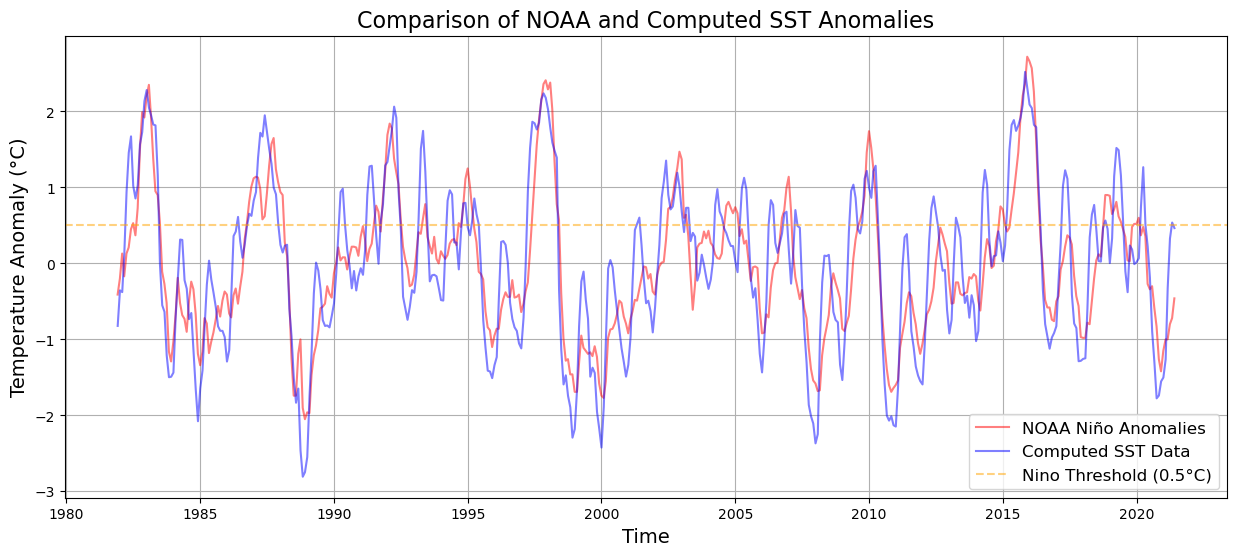

In [13]:
#Visualize the SST and Noa Data
plt.figure(figsize =[15, 6])

# Plot the NOAA data
plt.plot(
    noaa_series_common["time"],  
    noaa_series_common["anomaly_noaa"],  
    label = "NOAA Niño Anomalies", 
    color = "red",  
    linestyle = "-", 
    alpha = 0.5 
)

# Plot the SST data
plt.plot(
    nino_sst_anomaly_df["time"],  
    nino_sst_anomaly_df["anomaly_calculated"],  
    label="Computed SST Data", 
    color = "blue", 
    linestyle = "-", 
    alpha = 0.5 
)


plt.axhline(0.5, color = "orange", linestyle = "--", label = "Nino Threshold (0.5°C)", alpha = 0.5 )  
plt.title("Comparison of NOAA and Computed SST Anomalies", fontsize = 16)
plt.xlabel("Time", fontsize = 14)
plt.ylabel("Temperature Anomaly (°C)", fontsize = 14)
plt.legend(fontsize = 12)
plt.grid(True)

# Save the graph
plt.savefig("images/comparison_noaa_sst.png")
plt.show()

## Removing the Seasonal Cycle 

We want to remove the seasonal cycle to see if we can predict El Nino events better 

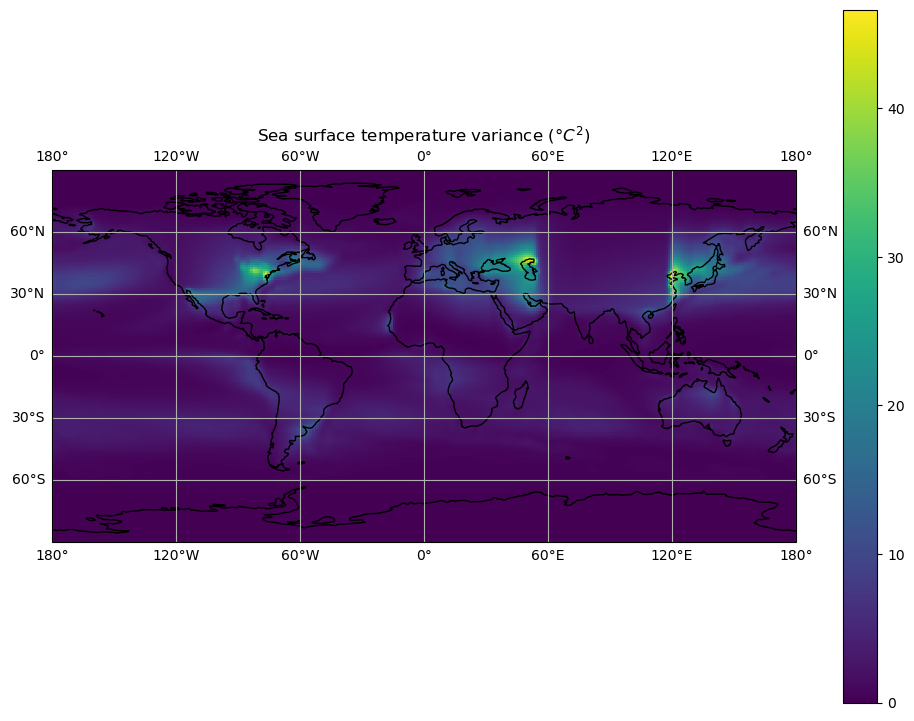

In [14]:
sst = sst_ds.sst
# Compute the mean
sst_mean = sst.mean('time') 
# Compute deviations from the mean
sst_dev = sst - sst_mean
# Get grid-point area coefficients
coef = np.cos(np.deg2rad(sst['lat']))
# Scale height by coefficient
sst_scaled = sst_dev * coef


# Plot scaled variance with costlines and gridlines
fig = plt.figure(figsize = [12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = sst_scaled.var('time').plot(ax = ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Sea surface temperature variance (°$C^2$)')

C:\Users\natha\AppData\Local\Temp\ipykernel_18384\1167569016.py:10: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in g.axes.flat:


<Figure size 640x480 with 0 Axes>

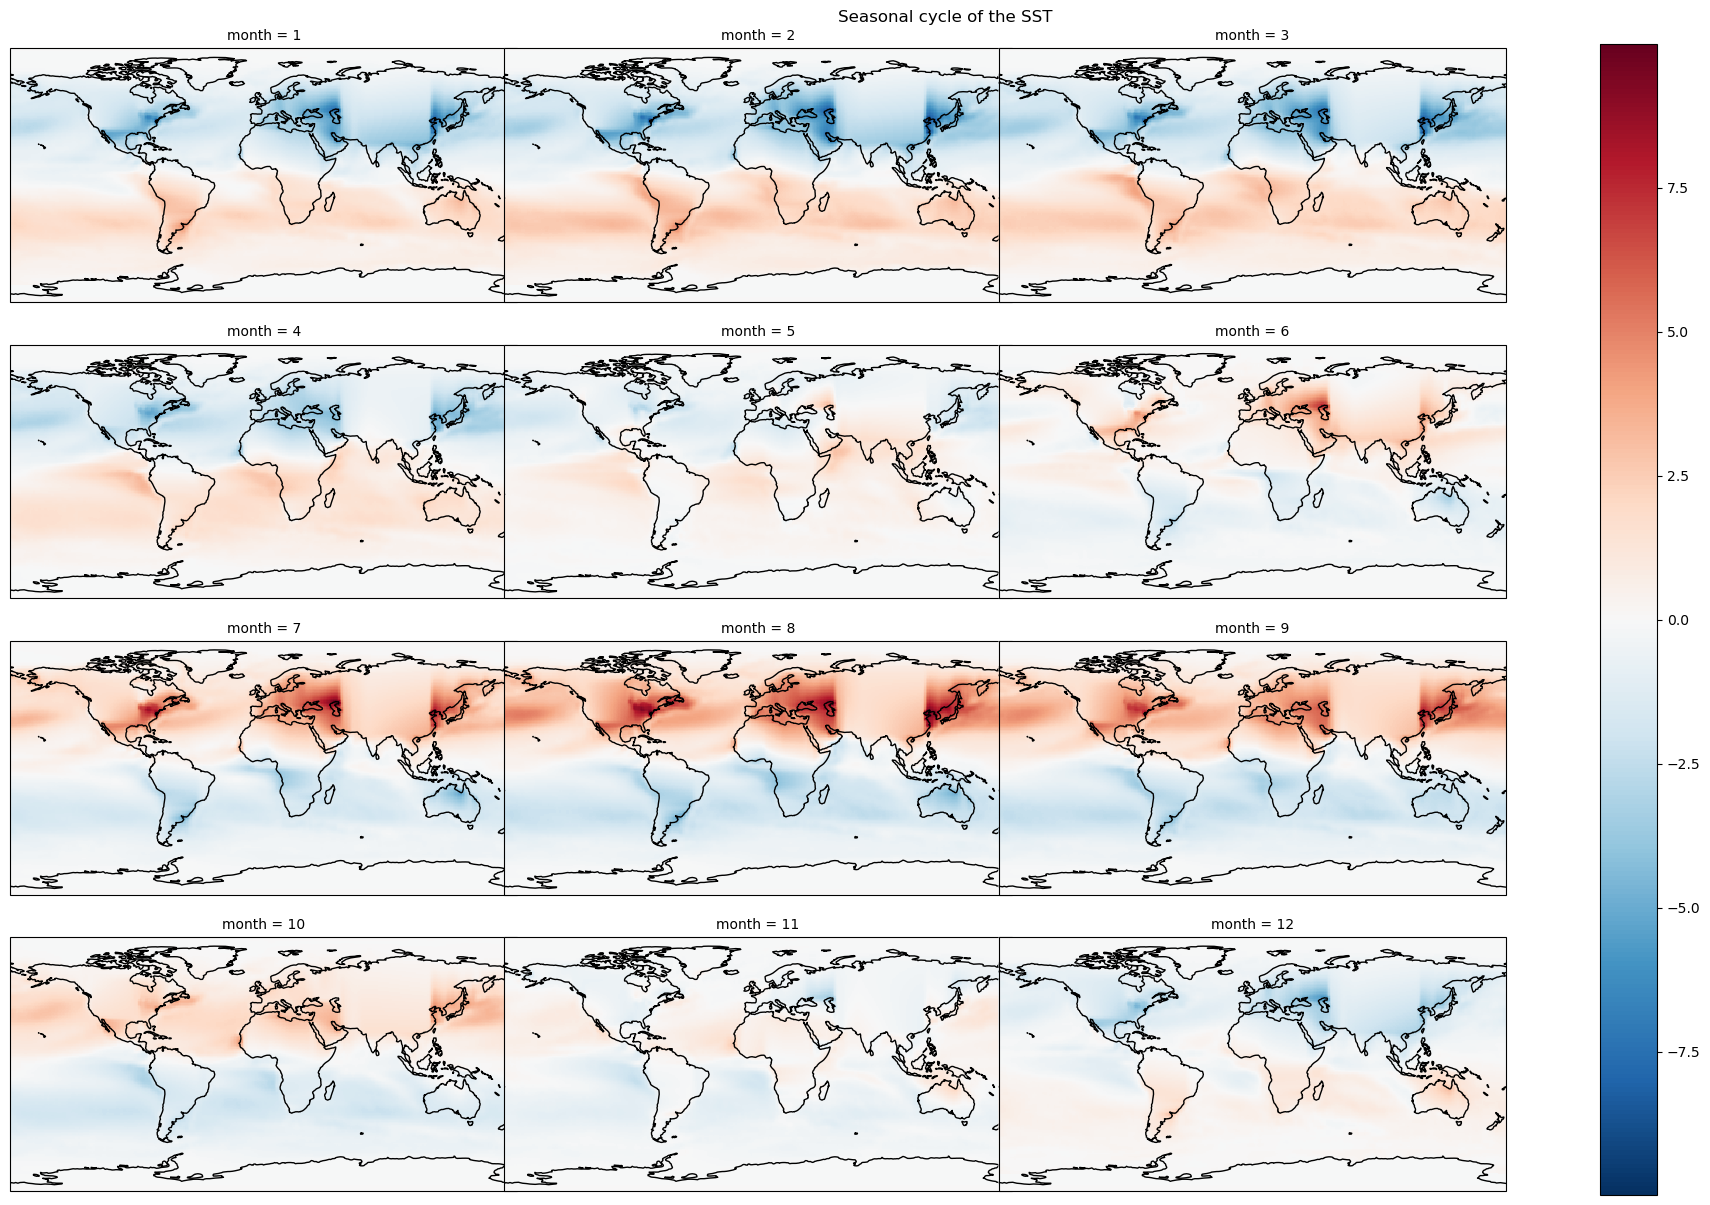

In [15]:
# Compute monthly seasonal cycle
gps = sst_scaled.groupby('time.month')
# Get seasonal cycle
sst_seasonal = gps.mean()

# Plot each month of seasonal cycle
fig = plt.figure()
col_wrap = 3
g = sst_seasonal.plot(x='lon', y='lat', col='month', col_wrap=col_wrap, subplot_kws=dict(projection=ccrs.PlateCarree()),aspect=2)
for ax in g.axes.flat:
    ax.coastlines()
_ = plt.suptitle('Seasonal cycle of the SST', y=1)

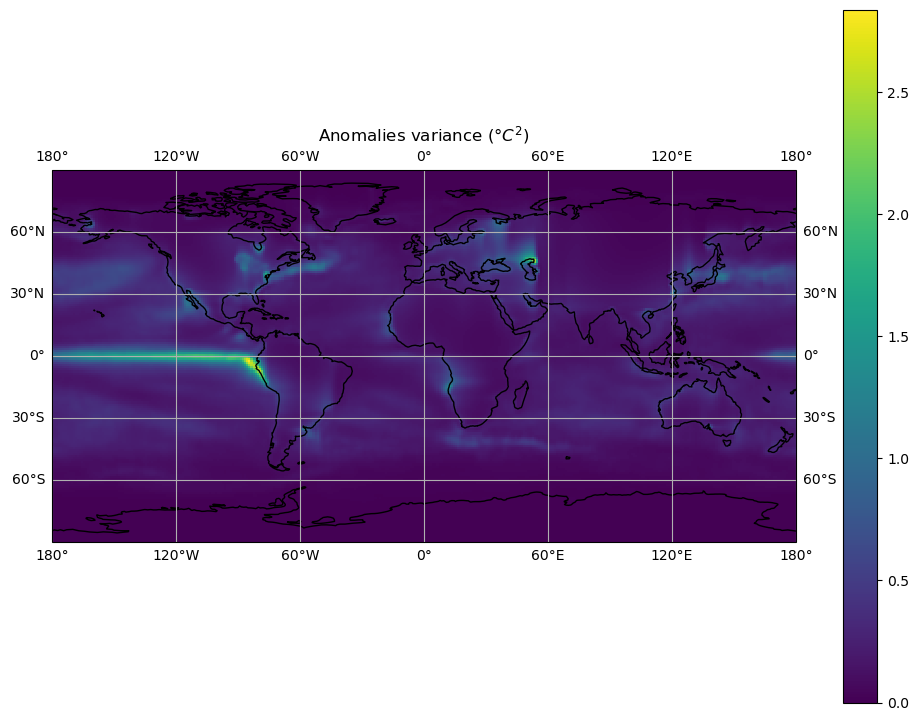

In [16]:
# Get seasonal anomalies
sst_anom_seasonal = sst_scaled.groupby('time.month') - sst_seasonal

# Plot variance of the seasonal anomalies on a map
fig = plt.figure(figsize=[12, 9])
ax = plt.subplot(projection=ccrs.PlateCarree())
p = sst_anom_seasonal.var('time').plot(ax=ax)
ax.coastlines()
ax.gridlines(draw_labels=True)
_ = ax.set_title(r'Anomalies variance (°$C^2$)')

Now let's do the same thing as in the previous part: we already have y, let's create X

In [17]:
# Let's create our dataset for the prediction 1 month in advance
# We have to suppress the First and the Last month of the original dataset
all_months = pd.to_datetime(nino_sst_anomaly.time.values)

# We keep the same y_1m as before
y_1m_seasonal = y_1m

# Let's create X: extract the SST data for all valid months
sst_global_data_seasonal = sst_anom_seasonal.sel(time = slice(all_months[0], all_months[-2]))
X_1m_seasonal = sst_global_data_seasonal.values.reshape(len(all_months) - 1, -1)  #Flatten the data by month 

# Verify that the size are correct 
print(X_1m_seasonal.shape, y_1m_seasonal.shape)

#Save the data under the format .npz
np.savez_compressed("data/preprocessed_data/nino_dataset_1m_seasonal.npz", X=X_1m_seasonal, y=y_1m_seasonal)

(474, 64800) (474,)
